# <font color ="FFA500">Forecasting Inflation rates with SARIMA </font>


**SARIMA** is an extension of the regular ARIMA model that adds a seasonality component to the model. This allows us to better capture seasonal affects that the regular ARIMA model does not permit.
To produce SARIMA(p, d, q)(P, D, Q)m,  a seasonality component is added to each factor of the classic ARIMA equation 

$$
y_t' = c + \sum_{n=1}^{p} \phi_n y_{t-n}' + \sum_{n=1}^{q} \theta_n \varepsilon_{t-n} 
+ \sum_{n=1}^{P} \eta_n y_{t-mn}' + \sum_{n=1}^{Q} \omega_n \varepsilon_{t-mn} + \varepsilon_t
$$
 Where:

y’: differenced time series, through both regular, d, and seasonal, D, differencing
P: number of seasonal auto-regressors
ω: coefficients of the seasonal autoregressive components
Q: number of seasonal moving-average components
η: coefficients of the seasonal forecast errors
m: length of season


### Limitation of SARIMA

One key limitation of the **SARIMA** model is that it **cannot handle multiple seasonalities**.  
It is designed to capture only a **single seasonal pattern** (e.g., monthly or weekly), making it unsuitable for datasets that exhibit **more than one seasonal cycle** (e.g., both daily and yearly patterns).






## <font color ="FFA500">Key Considerations</font>

### 1. Stationarity Requirement

SARIMA models require the time series to be **stationary**, meaning:
- No long-term trend or persistent seasonality
- Constant mean and variance over time

To achieve stationarity:
- **Mean stabilization** is done through differencing:
  - Regular differencing → order \( d \)
  - Seasonal differencing → order \( D \)
- **Variance stabilization** can be achieved using:
  - Log transformation
  - Box-Cox transformation  
These help normalize the amplitude of seasonal fluctuations across time.

---

### 2. Order Selection

Once the series is stationary, we determine the model orders:

#### a. Differencing Orders 
- \( d \): Number of regular differences  
- \( D \): Number of seasonal differences  
Use the **Augmented Dickey-Fuller (ADF)** test to assess whether differencing is required.

#### b. AR and MA Orders  
- Regular terms: \( p \) (AR), \( q \) (MA)  
- Seasonal terms: \( P \) (SAR), \( Q \) (SMA)  
Analyze:
- **Partial Autocorrelation Function (PACF)** → identifies AR (p, P)  
- **Autocorrelation Function (ACF)** → identifies MA (q, Q)  



---



# `Data Loading and Visualization`

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
infl_df = pd.read_csv('I:/CQAI/TSA/Notebooks/inflation rates dataset.csv')

In [3]:
# infl_df["Date"] =pd.to_datetime(infl_df['Year'].astype(str) + '-' + infl_df['Month'].astype(str) + '-01')
infl_df["Date"]= pd.to_datetime(infl_df["Date"])




In [4]:
infl_df=infl_df.set_index("Date")
infl_df

,Unnamed: 0,Monthly_Inflation
Date,,
1960-01-01,0,NaN
1960-02-01,1,1.000000
1960-03-01,2,0.991323
1960-04-01,3,1.008753
1960-05-01,4,1.006508
...,...,...
2019-09-01,716,1.006250
2019-10-01,717,1.009317
2019-11-01,718,1.009231


In [5]:
infl_df.columns
infl_df = infl_df.drop(columns="Unnamed: 0")

In [6]:
infl_df.columns

Index(['Monthly_Inflation'], dtype='object')

In [7]:
infl_df.isnull().sum()

Monthly_Inflation    2
dtype: int64

In [8]:
infl_df.dropna(inplace= True)

In [9]:
infl_df.index.duplicated().sum()  # check for duplicate timestamps

0

In [16]:
infl_df.loc["2017-01-01", "Monthly_Inflation"]

0.9963636363636392

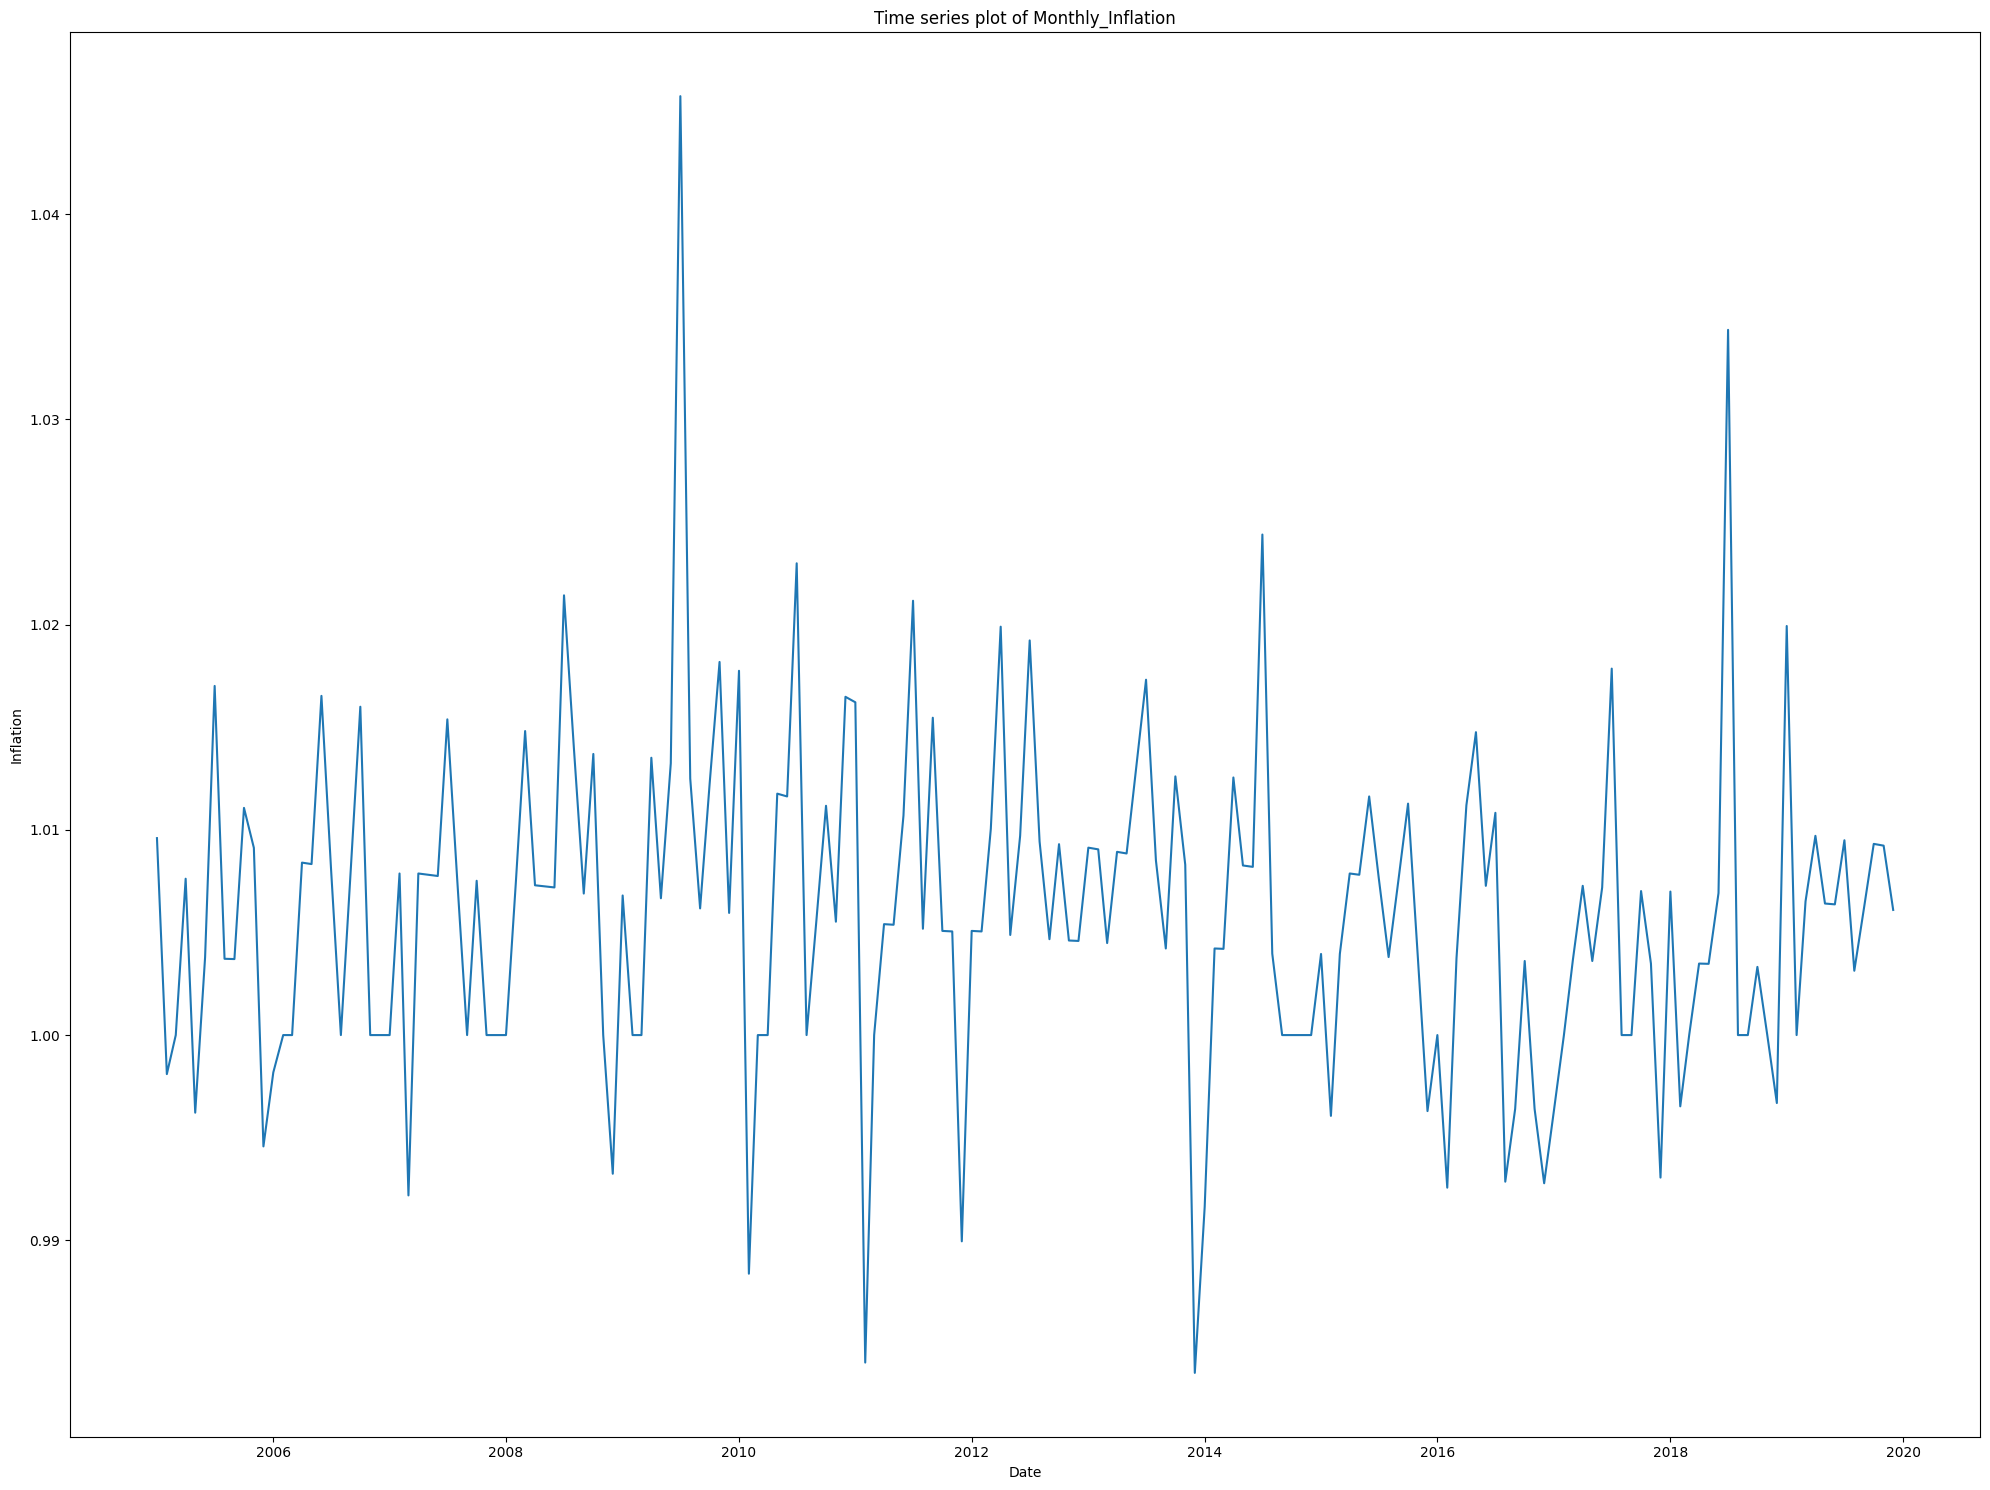

In [22]:
import seaborn as sns

plt.figure(figsize=(20, 15))
plt.plot(infl_df.loc["2005-01-01":].index, infl_df.loc["2005-01-01":], label="Inflation")


plt.title(f"Time series plot of {"Monthly_Inflation"}")
plt.xlabel("Date")
plt.ylabel("Inflation")  
plt.tight_layout()
plt.show()

# `Seasonal Decomposition`

This technique allows us to identify three main components of time series:

1. **Trend** – the long-term progression or direction of the data.
2. **Seasonality** – repeating patterns or cycles at regular intervals (e.g., yearly, monthly).
3. **Residual** – random noise or irregular fluctuations after removing trend and seasonality.


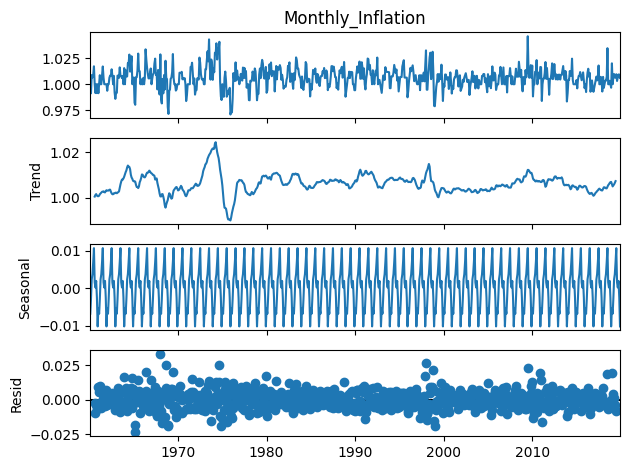

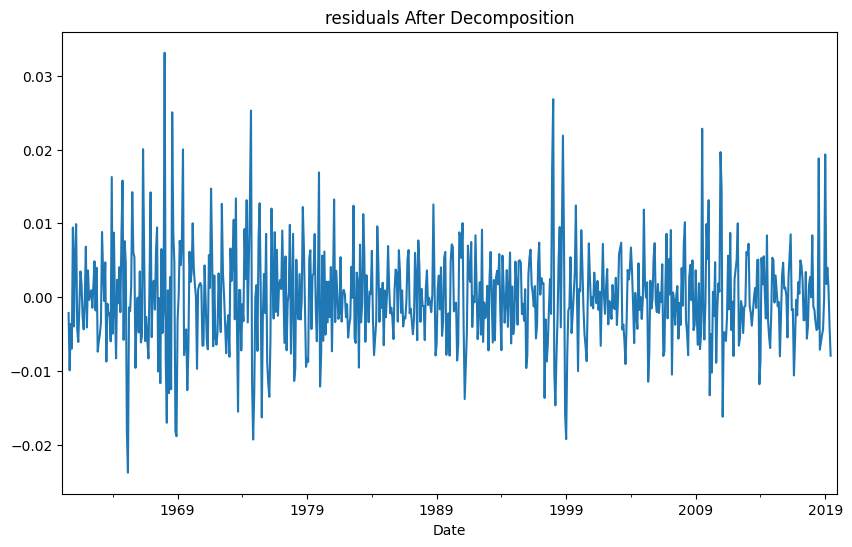

In [24]:

from statsmodels.tsa.seasonal import seasonal_decompose
df =infl_df.dropna()
# Decompose the time series data
result = seasonal_decompose(infl_df["Monthly_Inflation"], model='additive', period=12)# additive model in this case will give A good residual plot = random noise → model fits well.  
# Plot decomposition
result.plot()

plt.show() 
# Plot residuals
residual = result.resid
residual.plot(figsize=(10, 6))
plt.title("residuals After Decomposition")
plt.show()




**OBSERVATION**:
- There is no visible downward or upward trend however the  seasonality is very evident. THis suggests the time series is non stationary


# `Analyzing ACF Plots for Seasonality check`
- The autocorrelation graph displays the correlation between the observations at the current point in time and the observations at all previous points in time. Repearing spikes in autocorrelation graphs gives us an idea about presence of seasonlity


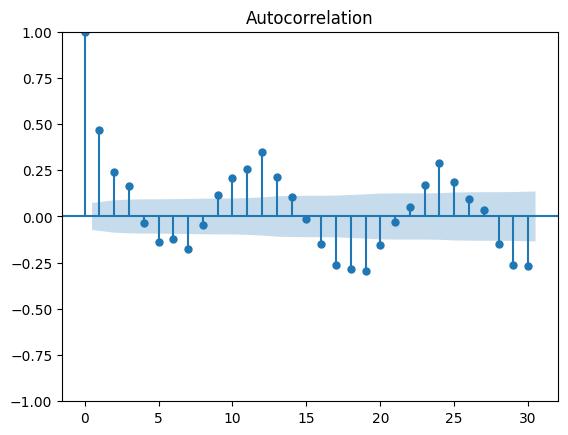

In [25]:
# subtracting the current value from the previous value
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(infl_df["Monthly_Inflation"], lags=30)
plt.show()
plt.show()


**OBSERVATION**:
- In the  plot we observe significant spikes for most of the lags  and a clear repeating pattern  which indicates presence of seasonality


# `Individual check on Trend and  Seasonlaity using Mankendall and Freidmanchisquare test`


In [23]:
col="Monthly_Inflation"

In [24]:
import pymannkendall as mk
# Perform Mann-Kendall test

result = mk.original_test(infl_df[col].dropna())
print(result)

Mann_Kendall_Test(trend='no trend', h=False, p=0.602270082239404, z=-0.5211388020751264, Tau=-0.012978409350653376, s=-3350.0, var_s=41297472.666666664, slope=0.0, intercept=1.006125574268749)


In [25]:
from scipy.stats import friedmanchisquare
def seasonality_check(col):
    # Drop NaNs (e.g., from differencing)
    values = infl_df[col].dropna().values

    # Ensure the length is divisible by 12 (e.g., complete years)
    length = len(values) - (len(values) % 12)
    values = values[:length]

    # Reshape to (n_years, 12 months)
    data = values.reshape(-1, 12)

    # Apply Friedman test across columns (months)
    stat, p = friedmanchisquare(*data.T)
    print(f"Friedman p-value: {p:.6f}")  

    # If p-value < 0.05, reject the null hypothesis of equal distributions across months
    if p < 0.05:
        print("There are significant differences in the distributions of electric production across months, Means Seasonality exists.")   
    else:
        print("No significant differences in the distributions of electric production across months, Seasonality does not exist.")

seasonality_check("Monthly_Inflation")

Friedman p-value: 0.000000
There are significant differences in the distributions of electric production across months, Means Seasonality exists.


- **Results**
- No Trend 
- Presence of Strong Seasonality
- The data is non stationary



# `Seasonal Differencing to achieve Stationary`

In [29]:

infl_df['seasonal_adjusted_inflation_rate'] = infl_df['Monthly_Inflation'] - infl_df['Monthly_Inflation'].shift(12)
#inf_df2=infl_df.dropna()

In [34]:
col="seasonal_adjusted_inflation_rate"

In [54]:
seasonality_check("seasonal_adjusted_inflation_rate")

Friedman p-value: 0.996922
No significant differences in the distributions of electric production across months, Seasonality does not exist.


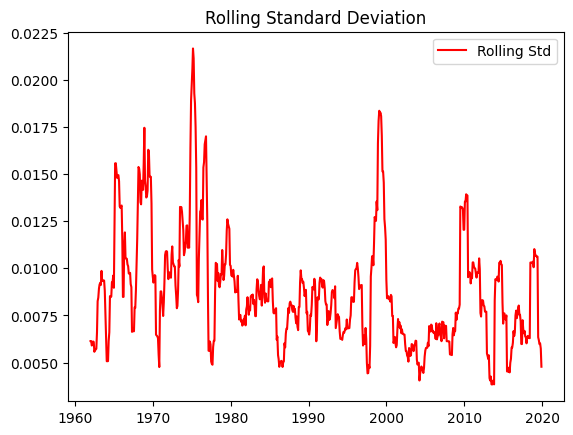

In [38]:
def plot_roll_mean_std(df,col):

    rolling_std =df[col].rolling(window=12).std()

  
    plt.plot(rolling_std, label='Rolling Std', color='red')
   
    plt.legend()
    plt.title("Rolling Standard Deviation")
    plt.show() 
plot_roll_mean_std(infl_df,"Monthly_Inflation")


# `Determining order of SARIMA using ACF/PACF Plots on Seasonally adjusted data`
-The autocorrelation graph displays the correlation between the observations at the current point in time and the observations at all previous points in time. Spike in autocorrelation graphs tells us the number of Auto-Regressive (AR) terms or the number of lags.
- The partial autocorrelation graph displays the duration of the influence of a random shock, i.e. correlation which is not explained by the set of explanatory variables. Spike in the partial autocorrelation tells us the number of Moving Average (MR) Terms.

---
- On the  y_axis we have the pearson correatation values between -1 and 1 , 1 = perfect posiitve correatlion, -1 = perfect negative correlation and 0 = no correaltion.
- The shaded region in both the graphs represents a 95% confidence interval band. 
- Anything outside the shaded region signifies a statistically significant correlation.
- Anything within the shaded region signifies no significant correltion

In [31]:
infl_df.dropna(inplace = True)

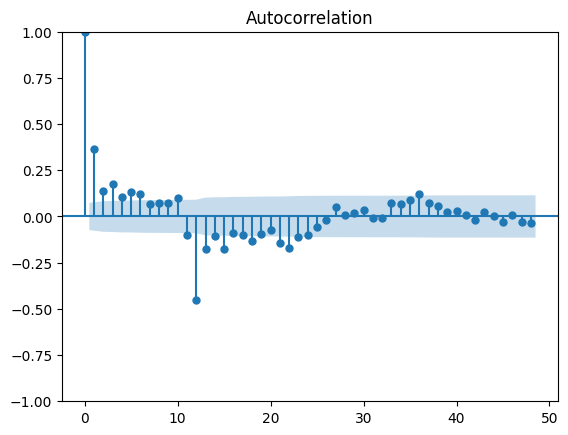

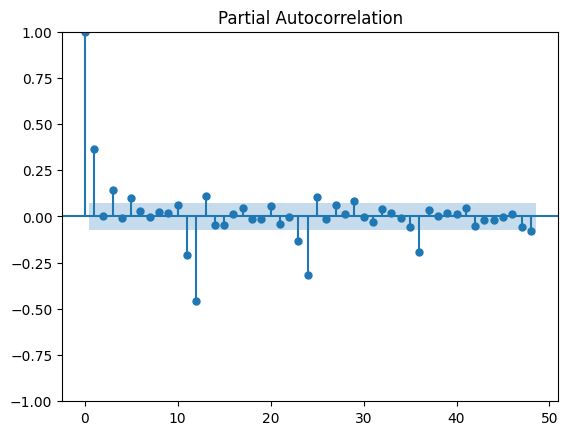

In [32]:
# subtracting the current value from the previous value
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(infl_df[col], lags=48)
plt.show()

plot_pacf(infl_df[col], lags=48)
plt.show()

### **Observations**

#### 🔹 *Non-Seasonal tems - AR(p), MA(q)*  
- **ACF for MA** shows significant autocorrelations fom **lags 1 and  3** so we choose either 1,3 or 5 for q, 
- **PACF for AR** shows prominent spikes at **lags 1 and 3**

#### 🔹 *Seasonal terms - AR(P) MA(Q) determined as  (Multiples of 12)*  
- **ACF for MA** shows a clear **negative spike at lag 12**, so we select the lag 1 ( multiple of 12) for seasonal Q.  
- **PACF** shows significant spikes at **lags 12, and 24**, so we select the lag 1 or lag 2 (multiples of 12) for seasonal P.

---

### **Model Parameters to Consider**

#### 🔹 *Non-Seasonal Terms*  : we will not consider lag 3 to avoid overfitting
- **AR terms (p):** {0,1}  
- **MA terms (q):** {0,1}


#### 🔹 *Non Seasonal Terms*  
- **AR terms (P):** {0,1, 2}  
- **MA terms (Q):** {0,1}



**NOTE**; The d/D value will be 0 since the data is already stationary in mean i.e it showed no trend  and we did not need to differnce it .


# `Train/Test Split`

In [105]:
len(infl_df["Monthly_Inflation"])

707

In [130]:
infl_df.asfreq('ME')
train = infl_df["Monthly_Inflation"][:-18]
test = infl_df["Monthly_Inflation"][-18:]# last 48 months for test data

In [131]:
test.head()

Date
2018-07-01    1.034364
2018-08-01    1.000000
2018-09-01    1.000000
2018-10-01    1.003322
2018-11-01    1.000000
Name: Monthly_Inflation, dtype: float64

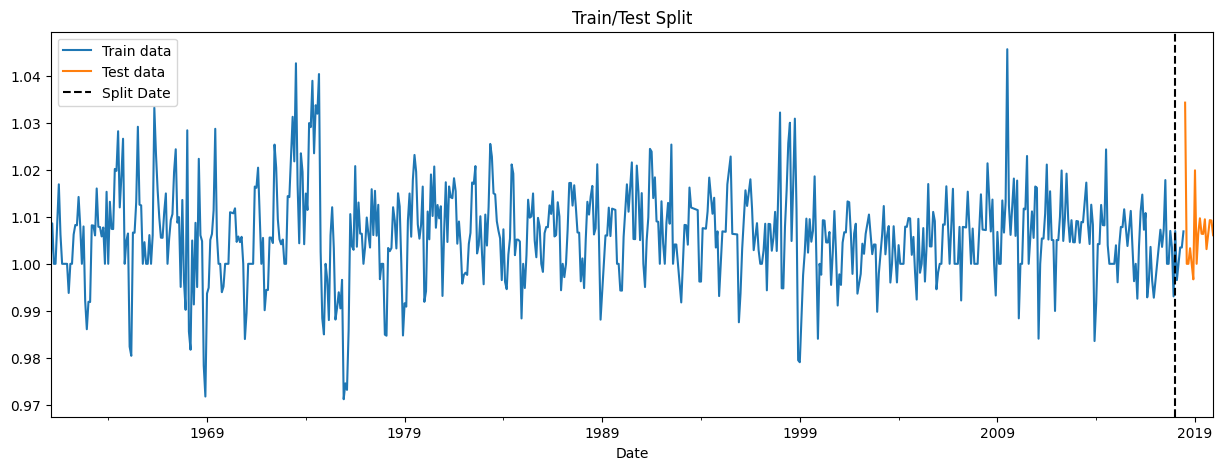

In [132]:


fig, ax = plt.subplots(figsize=(15, 5))  

train.plot(ax=ax, label="Train data")
test.plot(ax=ax, label="Test data")

ax.axvline("2018-01-01", color="black", linestyle="--", label="Split Date")  # ✅ pass an actual date value

ax.legend()
plt.title("Train/Test Split")
plt.show()


# `Modeling with Sarima`

## Using Auto ARIMA to Detect the Best Order by AIC

`Auto_arima` is commonly used to automatically determine the best (p, d, q) and (P, D, Q, s) order for ARIMA/SARIMA models. IT aims to select a model that fits the data well **without being overly complex** 
By default, it selects the model with the **lowest AIC (Akaike Information Criterion)**, but this can be changed to BIC.

---

### Model Selection Criteria

-- **AIC (Akaike Information Criterion):**  
  Evaluates model quality by balancing fit and complexity.  
##### AIC Formula

$$
\text{AIC} = -2 \cdot \ln(\text{Likelihood}) + 2k
$$
Where:  
- $ \ln(\text{Likelihood}) $: Measures how well the model fits the data  
- $ k $: Number of model parameters
---

### 🔹 What This Means:
- The **first term** rewards better model fit (higher likelihood → lower AIC).
- The **second term** penalizes model complexity (more parameters increase AIC).
- So: **More parameters → higher AIC**, unless they substantially improve the fit.

→ **Lower AIC** indicates a better trade-off between goodness of fit and model simplicity.

- **BIC (Bayesian Information Criterion):**  
  Similar to AIC but applies a **stronger penalty** for model complexity.  
  → Often results in **simpler models**, reducing the risk of overfitting.

---

**BIC (Bayesian Information Criterion):**  
  Measures model quality with a stronger penalty for complexity compared to AIC.  
  It is especially useful when aiming for simpler, more generalizable models.

##### BIC Formula

$$
\text{BIC} = -2 \cdot \ln(\text{Likelihood}) + k \cdot \ln(n)
$$

Where:  
- $ \ln(\text{Likelihood}) $: Measures how well the model fits the data  
- $ k $: Number of model parameters  
- $ n $: Number of observations (sample size)
---

### 🔹 What This Means:
- The **first term** rewards better model fit (higher likelihood → lower BIC).  
- The **second term** penalizes model complexity more heavily than AIC, especially as sample size \( n \) increases.  
- So: **More parameters → much higher BIC**, unless they greatly improve the fit.

→ **Lower BIC** indicates a simpler, more parsimonious model that still fits the data well.


In [133]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")




stepwise_model = auto_arima(train,
                             seasonal=True, m=12, 
                             trace=True,
                             information_criterion='aic',
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

print(f"\nBest SARIMA model order: {stepwise_model.order} Seasonal Order: {stepwise_model.seasonal_order}")





Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-4418.845, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=2.33 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-4613.820, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1965.803, Time=0.29 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-4569.519, Time=0.27 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-4582.841, Time=1.65 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-4621.079, Time=2.45 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-4617.558, Time=5.33 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-4491.622, Time=1.67 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-4639.876, Time=3.43 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-4629.996, Time=4.20 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=4.40 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-4663.133, Time=2.14 sec
 ARIMA(1,0,1)(1,0,0)[12] 

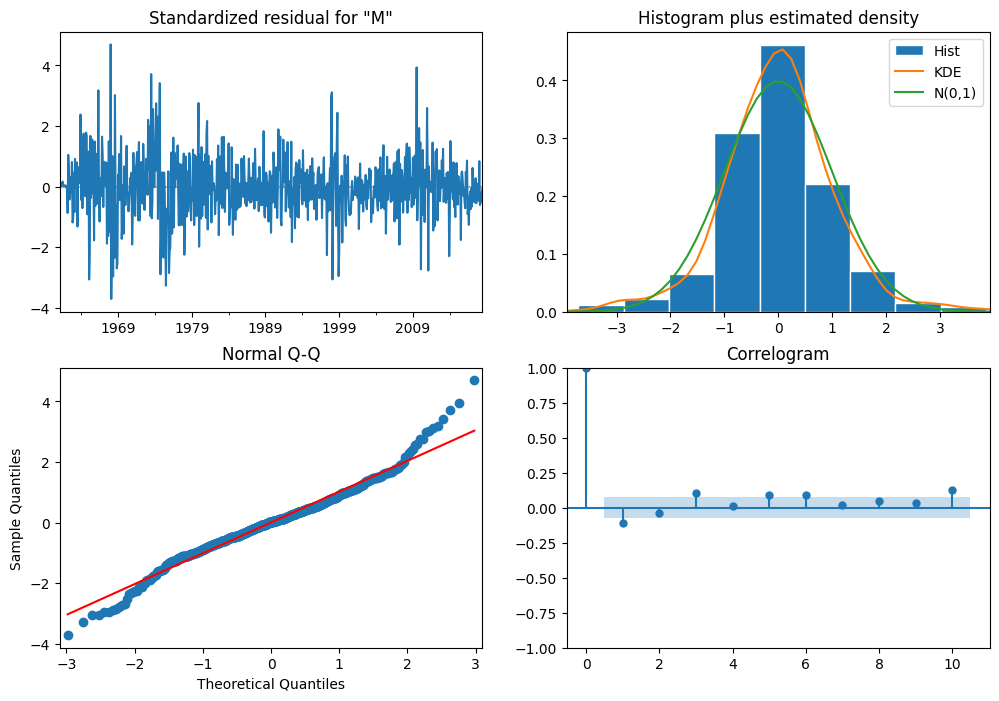

In [134]:



model1 = SARIMAX(train,
                order=stepwise_model.order,
                seasonal_order=stepwise_model.seasonal_order,
               
                 trend='c',
               ).fit(disp=True)


# Step 6: Model diagnostics
model1.plot_diagnostics(figsize=(12, 8))
plt.show()

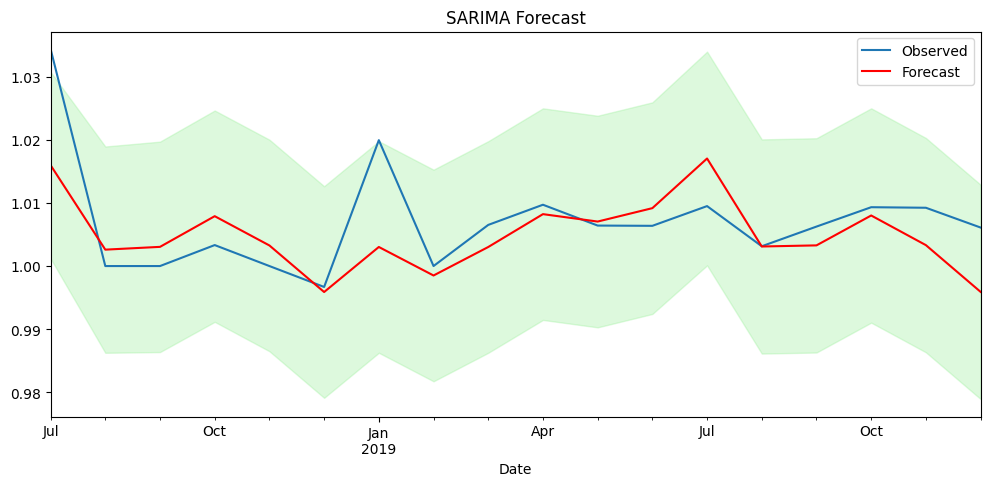

In [135]:
# Step 7: Forecast future values
n_forecast = len(test) 


forecast1 = model1.get_forecast(steps=n_forecast)
forecast_mean1 = forecast1.predicted_mean
forecast_ci1 = forecast1.conf_int()

# Plot the forecast
ax = test.plot(label='Observed', figsize=(12, 5))
forecast1.predicted_mean.plot(ax=ax, label='Forecast', color='red')
ax.fill_between(forecast_ci1.index,
                forecast_ci1.iloc[:, 0],
                forecast_ci1.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.legend()
plt.title("SARIMA Forecast")
plt.show()


# `Modeling with Manually detected orders with ACF and PACF`

### **Model Parameters to Consider**

#### 🔹 *Non-Seasonal Terms*  
- **(p):** 1  
- **(q):** 0


#### 🔹 *Non Seasonal Terms*  
- **AR terms (P):** 2  
- **MA terms (Q):** 1


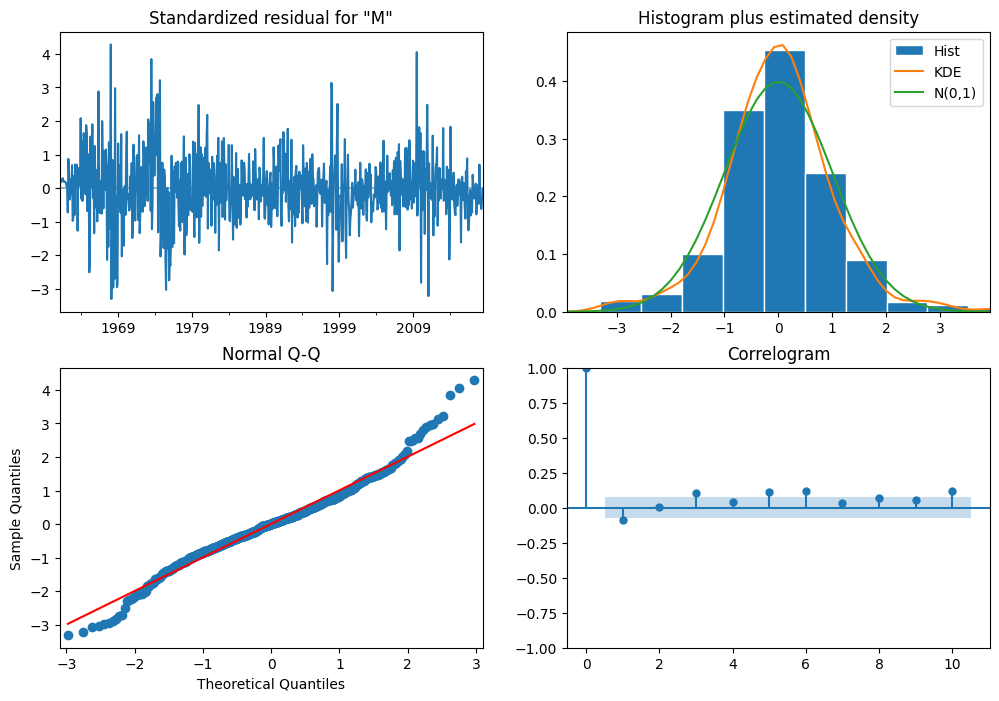

In [154]:



model2 = SARIMAX(train,
                order=(1,0,0),
                seasonal_order=(2,0,1,12),
               
                 trend='c',
               ).fit(disp=True)


# Step 6: Model diagnostics
model2.plot_diagnostics(figsize=(12, 8))
plt.show()

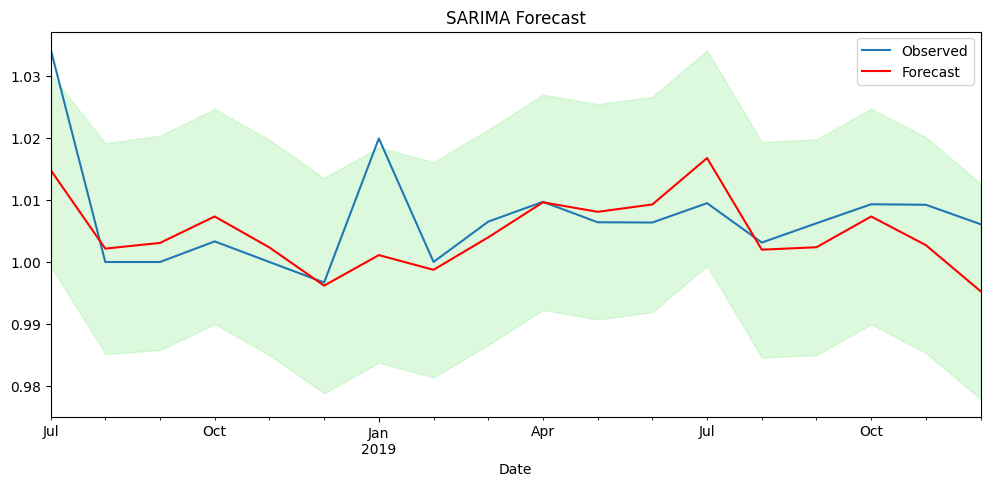

In [155]:
# Step 7: Forecast future values
n_forecast = len(test) 


forecast2 = model2.get_forecast(steps=n_forecast)
forecast_mean2 = forecast2.predicted_mean
forecast_ci2 = forecast2.conf_int()

# Plot the forecast
ax = test.plot(label='Observed', figsize=(12, 5))
forecast2.predicted_mean.plot(ax=ax, label='Forecast', color='red')
ax.fill_between(forecast_ci2.index,
                forecast_ci2.iloc[:, 0],
                forecast_ci2.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.legend()
plt.title("SARIMA Forecast")
plt.show()


In [156]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate MAE and RMSE for both models
mae1 = mean_absolute_error(test, forecast_mean1)
rmse1 = np.sqrt(mean_squared_error(test, forecast_mean1))

mae2 = mean_absolute_error(test, forecast_mean2)
rmse2 = np.sqrt(mean_squared_error(test, forecast_mean2))

# Print results clearly
print("Mean Value of Test Dataset:", test.mean())
print(f"Test MAE Model 1: {mae1:.2f}")
print(f"Test RMSE Model 1: {rmse1:.2f}")
print(f"Test MAE Model 2: {mae2:.2f}")
print(f"Test RMSE Model 2: {rmse2:.2f}")


Mean Value of Test Dataset: 1.007046414631508
Test MAE Model 1: 0.00
Test RMSE Model 1: 0.01
Test MAE Model 2: 0.01
Test RMSE Model 2: 0.01


# `Final Results`

Based on the error metrics, both models appear to perform well.  
However, the **MAE for Model 1 is 0**, which is highly unusual and may indicate **Overfitting** to the training data  :


